# Pre_processing

In [ ]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-13e042af-3930-86f3-aec0-888c632e8518)


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/Final_Project/train.zip -d /content

In [ ]:
%tensorflow_version 1.x # 코랩에서 텐써플로우 1.x 버전으로 코드를 수행하기 위한 명령어

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # 코랩에서 텐써플로우 1.x 버전으로 코드를 수행하기 위한 명령어`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [ ]:
## Import modules 

%cd /content/gdrive/MyDrive

import Functions
import os 
import re
import cv2
import csv
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

/content/gdrive/MyDrive


## Resize

In [ ]:
## Resize & create file by order:asc

path_raw = '/content/gdrive/MyDrive/Hyug_Won/train'
path_re = "/content/gdrive/MyDrive/Hyug_Won/raw/car_resize"

loader_hyug.resize(path_raw, path_re, height=256, width=144)  #default = 128*128

## Load X : Features

In [ ]:
## Load X : Features

path_re = '/content/train'


resize = image_load(path_re)
resize.shape

(5004, 256, 256, 3)

(5004, 256, 256, 3)


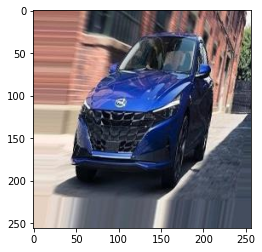

In [ ]:
## Check out first img(resized)

img = resize[0, : ]
plt.figure()
plt.imshow(img)
print(resize.shape)  

In [ ]:
## Make X (feature)

X = resize
X.shape  

(5004, 256, 256, 3)

## Create Label

### Create Csv file

In [ ]:
## Make csv file in path_re

path_re = "D:\\LSS_project\\Data\\re.csv"
loader_hyug.csv_maker_84(path_re, k1=10, k2=600)


### Load y : label

In [ ]:
path = "/content/gdrive/MyDrive/Final_Project/final_lable.csv"
y = loader_hyug.label_load(path,label_cnt=3)  
y.shape


(5004, 3)

## Scaling

In [ ]:
X = X.astype('float')
X = X/255
X.shape   

(5004, 256, 256, 3)

## Check X, y

In [ ]:
## Confirm X, y
print(X.shape)  
print(y.shape, end='\n\n\n')  


(5004, 256, 256, 3)
(5004, 3)




# Modeling

In [ ]:
## module import
import tensorflow as tf # tensorflow 2.0
from tensorflow.keras.models import Sequential, save_model,load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Activation
from tensorflow.keras.layers import Dropout, BatchNormalization, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


## Transfer Learning
from tensorflow.keras.applications.vgg19 import VGG19
#from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
# 훈련/테스트 데이터를 0.7/0.3의 비율로 분리합니다.
x_train, x_val, y_train, y_val = train_test_split(X, y, 
                                                test_size = 0.3, 
                                                random_state = 343)

# Checkout
print(x_train.shape)
print(x_val.shape)  
print(y_train.shape)
print(y_val.shape)  

(3502, 256, 256, 3)
(1502, 256, 256, 3)
(3502, 3)
(1502, 3)


In [ ]:
## VGG 16 options

# vgg16 = VGG16(weights = 'imagenet', include_top = False, input_shape = (256, 256, 3))
# vgg16.summary()

## VGG 19 options

vgg19 = VGG19(weights = 'imagenet', include_top = False, input_shape = (256, 256, 3))
vgg19.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
80142336/80134624 [==============================] - 4s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 1

In [ ]:
## 가중치 초기값 : imagenet
# layer.trainable=True : 동결 해제 (default)
# layer.trainable=False : 동결 (option)

# for layer in vgg16.layers[:-4]:
#      layer.trainable = False


for layer in vgg19.layers[:-4]:
     layer.trainable = False

In [ ]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [ ]:
# 신경망 객체 생성
model = Sequential()

# stacking vgg19
model.add(vgg19)

# Reshape : Flatten 
model.add(Flatten())

# 완전연결계층1
model.add(Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.005)))  #default node num = 4096
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))  #traditional range : 0.2~0.5

# 완전연결계층2
model.add(Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.005)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# 출력층(softmax)
model.add(Dense(3))  # class : 3
model.add(Activation('softmax'))

# Check out model 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate = 0.00005), 
              metrics=['accuracy'])

# model.compile(loss='binary_crossentropy', 
#               optimizer="adam", 
#               metrics=['accuracy'])

In [ ]:
epochs = 5
batch_size=50
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

hist = model.fit(x_train, y_train, 
                 validation_data=(x_val, y_val), 
                 epochs=epochs, 
                 batch_size=batch_size,
                 callbacks = [early_stopping])

Train on 3502 samples, validate on 1502 samples
Epoch 1/5
3502/3502 [==============================] - 21s 6ms/sample - loss: 4.1662 - acc: 0.8090 - val_loss: 3.9160 - val_acc: 0.8715
Epoch 2/5
3502/3502 [==============================] - 15s 4ms/sample - loss: 3.5593 - acc: 0.9869 - val_loss: 3.5237 - val_acc: 0.9720
Epoch 3/5
3502/3502 [==============================] - 15s 4ms/sample - loss: 3.3266 - acc: 0.9971 - val_loss: 3.2713 - val_acc: 0.9860
Epoch 4/5
3502/3502 [==============================] - 15s 4ms/sample - loss: 3.1274 - acc: 0.9994 - val_loss: 3.0499 - val_acc: 0.9940
Epoch 5/5
3502/3502 [==============================] - 15s 4ms/sample - loss: 2.9464 - acc: 0.9991 - val_loss: 2.8727 - val_acc: 0.9947


In [ ]:
# list all data in history
print(hist.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


In [ ]:
## Visualization : Accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Visualization : Loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
## Check out accuracy

scores = model.evaluate(x_train, y_train, verbose=1)
scores2 = model.evaluate(x_val, y_val, verbose=1)

print("Vgg19 train Error : %.2f%%" % (100-scores[1]*100))
print("Vgg19 val Error : %.2f%%" % (100-scores2[1]*100))

In [ ]:
## Save model : .h5(Hdf5 type file)

save_path = "/content/gdrive/MyDrive/Final_Project/weight.h5"
save_model(model, save_path)  

# Testing 

In [ ]:
!unzip /content/gdrive/MyDrive/test/test.zip -d /content

In [ ]:
#### Model Test ####

weight = load_model("/content/gdrive/MyDrive/Final_Project/weight.h5")

raw_path = '/content/test2'
resize_path = '/content/gdrive/MyDrive/test/resize2'

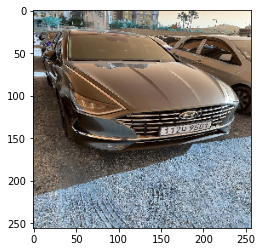

img shape (256, 256, 3)


In [ ]:
# Resize the test data images

resize(raw_path, resize_path, 256, 256)   

In [ ]:
# Load the test images

test_image = image_load(resize_path)
test_image.shape

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]


(50, 256, 256, 3)

In [ ]:
x_train = test_image.astype('float32')
x_train /= 255

In [ ]:
# Change Dimension of the Images
y = []
for i in range(x_train.shape[0]):
    y.append(np.expand_dims(x_train[i],axis = 0) )


In [ ]:
# Predictions

for idx, j in enumerate(y):
    result=weight.predict(j)
    a = np.argmax(result)
    if a == 0: 
        print(idx + 1, "Avante : {}%".format(result[0][a] * 100))
    elif a==1:
        print(idx + 1, "Grandeur : {}%".format(result[0][a] * 100))
    else:
        print(idx + 1, "Sonata : {}%".format(result[0][a] * 100))


1 Avante : 56.616491079330444%
2 Avante : 74.45020079612732%
3 Avante : 79.0309488773346%
4 Avante : 95.63438296318054%
5 Avante : 78.86214256286621%
6 Avante : 70.47726511955261%
7 Avante : 90.60885906219482%
8 Avante : 54.897499084472656%
9 Sonata : 96.89985513687134%
10 Grandeur : 78.09231877326965%
11 Grandeur : 96.3852047920227%
12 Grandeur : 84.6428632736206%
13 Grandeur : 80.05874156951904%
14 Grandeur : 92.2048568725586%
15 Grandeur : 50.453728437423706%
16 Grandeur : 97.47254252433777%
17 Grandeur : 51.607757806777954%
18 Grandeur : 51.89202427864075%
19 Grandeur : 69.55380439758301%
20 Grandeur : 78.9298951625824%
21 Grandeur : 92.10122227668762%
22 Grandeur : 91.32059216499329%
23 Grandeur : 99.64603781700134%
24 Grandeur : 98.47584962844849%
25 Grandeur : 96.19472622871399%
26 Sonata : 71.9993531703949%
27 Sonata : 98.13365340232849%
28 Avante : 49.25394654273987%
29 Sonata : 94.4116473197937%
30 Sonata : 96.25869989395142%
31 Sonata : 99.18403625488281%
32 Sonata : 69.2443